In [1]:
!nvidia-smi

No devices were found


In [2]:
#%load_ext cudf.pandas

# To desable GPU usage
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
#import cupy as cp
#import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import gc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # memory limit 16GB (16 * 1024 MB = 16384 MB) 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16384)] 
        )
        print("Set GPU memory limit to 16GB.")
    except RuntimeError as e:
        print("Error setting memory limit:", e)
else:
    print("No GPUs available.")

#print("Is torch using cuda? ",torch.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


2024-11-30 14:37:00.511262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 14:37:00.544163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 14:37:00.554227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 14:37:00.579514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No GPUs available.
Is tensorflow using cuda?  True
Is pandas using cuda?  <module 'pandas' from '/usr/local/lib/python3.11/dist-packages/pandas/__init__.py'>


2024-11-30 14:37:04.167555: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [3]:
name_mapping = [
    "box",
    "circularTorus",
    "cone",
    "coneOffset",
    "cylinder",
    "cylinderSlope",
    "dish",
    "mesh",
    "pyramid",
    "rectangularTorus",
    "sphere"
]

In [4]:
base_path = '/home/workspace/geometry-classifier/data/'
import os

In [5]:

def parse_tfrecord(example_proto):
    """
    Parses a serialized TFRecord example and extracts image and class label.
    """
    feature_description = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    name = tf.io.decode_raw(parsed_example['name'], tf.float32)
    image = tf.io.decode_raw(parsed_example['image'], tf.float32)
    image = tf.reshape(image, (224, 224, 1))  # Reshape image data to 224x224x1
    class_label = tf.cast(name[0], tf.int32)  # Use the first value in 'name' as a class label
    return image, class_label

def serialize_example(image, class_label):
    """
    Serializes an image and class label into a TFRecord example.
    """
    feature = {
        'name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[class_label.numpy().tobytes()])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()]))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

def filter_tfrecord(input_path, output_path):
    """
    Reads a TFRecord file, filters out rows with a class label of -1,
    and writes the remaining rows to a new TFRecord file.
    """
    # Create a TFRecord writer for the output file
    with tf.io.TFRecordWriter(output_path, options=tf.io.TFRecordOptions(compression_type="GZIP")) as writer:
        raw_dataset = tf.data.TFRecordDataset(input_path, compression_type="GZIP")
        for raw_record in raw_dataset:
            parsed_example = tf.io.parse_single_example(
                raw_record,
                {
                    'name': tf.io.FixedLenFeature([], tf.string),
                    'image': tf.io.FixedLenFeature([], tf.string)
                }
            )
            name = tf.io.decode_raw(parsed_example['name'], tf.float32)
            image = tf.io.decode_raw(parsed_example['image'], tf.float32)
            image = tf.reshape(image, (224, 224, 1))  # Reshape image
            class_label = tf.cast(name[0], tf.int32)

            # Filter out records with class_label == -1
            if class_label != -1:
                serialized_example = tf.train.Example(
                    features=tf.train.Features(
                        feature={
                            'name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[name.numpy().tobytes()])),
                            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()]))
                        }
                    )
                ).SerializeToString()
                writer.write(serialized_example)

def process_tfrecord_folder(input_folder, output_folder):
    """
    Processes all `.tfrecord.gz` files in a folder, filtering out rows with a class label of -1.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Use glob to find all `.tfrecord.gz` files in the folder
    input_files = glob.glob(os.path.join(input_folder, "*.tfrecord.gz"))

    for input_path in input_files:
        file_name = os.path.basename(input_path)
        output_path = os.path.join(output_folder, file_name)

        print(f"Processing {input_path} -> {output_path}")
        filter_tfrecord(input_path, output_path)


process_tfrecord_folder(base_path+"tfr_strat100-2min-notfiltered", base_path+"tfr_strat100-2min")

Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train462.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train462.tfrecord.gz


2024-11-30 14:37:08.506378: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train153.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train153.tfrecord.gz


2024-11-30 14:37:11.750932: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test54.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test54.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train314.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train314.tfrecord.gz


2024-11-30 14:37:18.429362: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train374.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train374.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train259.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train259.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test17.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test17.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train204.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train204.tfrecord.gz


2024-11-30 14:37:31.271880: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train68.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train68.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train230.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train230.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test106.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test106.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train235.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train235.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train43.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train43.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfil

2024-11-30 14:38:00.445097: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test8.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test8.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train285.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train285.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test134.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test134.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/val19.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/val19.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test133.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test133.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test

2024-11-30 14:38:58.703308: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train128.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train128.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train354.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train354.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train181.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train181.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test75.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test75.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test84.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test84.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfilte

2024-11-30 14:40:46.753710: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train450.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train450.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train288.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train288.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/val84.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/val84.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/val60.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/val60.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test50.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test50.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/trai

2024-11-30 14:44:24.377477: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train361.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train361.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train393.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train393.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/val64.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/val64.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train119.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train119.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train351.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train351.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfil

2024-11-30 14:51:45.337317: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test96.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test96.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test70.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test70.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test136.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test136.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train426.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train426.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/val67.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/val67.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/trai

2024-11-30 15:06:28.216144: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train446.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train446.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train66.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train66.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/test73.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/test73.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/val147.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/val147.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltered/train424.tfrecord.gz -> /home/workspace/geometry-classifier/data/tfr_strat100-2min/train424.tfrecord.gz
Processing /home/workspace/geometry-classifier/data/tfr_strat100-2min-notfiltere

In [6]:
!ls /home/workspace/geometry-classifier/data/

big_parquet.parquet  no-stratTF1		    tfr_strat50-1min
model1.keras	     photos_v3_parquet		    tfrecord
model4.keras	     tfr_strat100-2min		    tfrecord2
no-strat	     tfr_strat100-2min-notfiltered  training


In [7]:


def parse_tfrecord(example_proto):

    feature_description = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    name = tf.io.decode_raw(parsed_example['name'], tf.float32)
    image = tf.io.decode_raw(parsed_example['image'], tf.float32)
    image = tf.reshape(image, (224, 224, 1))  
    class_label = tf.cast(name[0], tf.int32)  
    return image, class_label

def load_tfrecord(tfrecord_files):

    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="GZIP")
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset


files_for = lambda file_type: glob.glob(f"{base_path}/tfr_strat100-2min/{file_type}*.tfrecord.gz")

test_files = files_for("test")
validation_files = files_for("val")
train_files = files_for("train")


test = load_tfrecord(test_files)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

validation = load_tfrecord(validation_files)
validation = validation.batch(32).prefetch(tf.data.AUTOTUNE)

train = load_tfrecord(train_files)
train = train.shuffle(14912).batch(32).prefetch(tf.data.AUTOTUNE)



In [8]:
# 224 x 224

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224,224,1)),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    

    layers.Flatten(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(11, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
checkpoint_callback = ModelCheckpoint(base_path+'model4.keras',save_best_only=True, save_weights_only=False, mode='min', verbose=1)
early_stopping = EarlyStopping(
    monitor="val_loss",   
    patience=10,
    restore_best_weights=True, 
    verbose=1
)

epochs = 100

In [10]:

cnn = model.fit(train, epochs=epochs,callbacks=[
    early_stopping,
    checkpoint_callback
], validation_data=validation)

Epoch 1/100


2024-11-30 15:22:01.790507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13337 of 23360
2024-11-30 15:22:08.701256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


  14912/Unknown 2725s 182ms/step - accuracy: 0.4846 - loss: 1.4933

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 1.17670, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2934s 196ms/step - accuracy: 0.4846 - loss: 1.4933 - val_accuracy: 0.5923 - val_loss: 1.1767
Epoch 2/100


2024-11-30 16:10:54.964788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13506 of 23360


    1/14912 ━━━━━━━━━━━━━━━━━━━━ 78:50:27 19s/step - accuracy: 0.5312 - loss: 1.4496

2024-11-30 16:11:03.577605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6684 - loss: 0.9398
Epoch 2: val_loss improved from 1.17670 to 1.02415, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3237s 216ms/step - accuracy: 0.6684 - loss: 0.9398 - val_accuracy: 0.6545 - val_loss: 1.0242
Epoch 3/100


2024-11-30 17:04:53.626141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 11410 of 23360
2024-11-30 17:05:02.869114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7214 - loss: 0.7844
Epoch 3: val_loss improved from 1.02415 to 0.92796, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3076s 205ms/step - accuracy: 0.7214 - loss: 0.7844 - val_accuracy: 0.6843 - val_loss: 0.9280
Epoch 4/100


2024-11-30 17:56:08.805883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13335 of 23360


    1/14912 ━━━━━━━━━━━━━━━━━━━━ 75:37:58 18s/step - accuracy: 0.6875 - loss: 0.8083

2024-11-30 17:56:15.764050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7507 - loss: 0.6964
Epoch 4: val_loss improved from 0.92796 to 0.89746, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3006s 200ms/step - accuracy: 0.7507 - loss: 0.6964 - val_accuracy: 0.6997 - val_loss: 0.8975
Epoch 5/100


2024-11-30 18:46:15.570509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12978 of 23360
2024-11-30 18:46:22.679087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7692 - loss: 0.6404
Epoch 5: val_loss improved from 0.89746 to 0.85343, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2919s 194ms/step - accuracy: 0.7692 - loss: 0.6404 - val_accuracy: 0.7150 - val_loss: 0.8534
Epoch 6/100


2024-11-30 19:34:53.434854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 11720 of 23360


    1/14912 ━━━━━━━━━━━━━━━━━━━━ 81:30:53 20s/step - accuracy: 0.7188 - loss: 0.6947

2024-11-30 19:35:01.861929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7819 - loss: 0.6021
Epoch 6: val_loss improved from 0.85343 to 0.81467, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2992s 199ms/step - accuracy: 0.7819 - loss: 0.6021 - val_accuracy: 0.7274 - val_loss: 0.8147
Epoch 7/100


2024-11-30 20:24:46.402122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13208 of 23360
2024-11-30 20:24:53.494232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7927 - loss: 0.5687
Epoch 7: val_loss did not improve from 0.81467
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2997s 200ms/step - accuracy: 0.7927 - loss: 0.5687 - val_accuracy: 0.7136 - val_loss: 0.8839
Epoch 8/100


2024-11-30 21:14:42.474646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13348 of 23360
2024-11-30 21:14:49.412308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8004 - loss: 0.5441
Epoch 8: val_loss improved from 0.81467 to 0.78589, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2887s 192ms/step - accuracy: 0.8004 - loss: 0.5441 - val_accuracy: 0.7453 - val_loss: 0.7859
Epoch 9/100


2024-11-30 22:02:49.777480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13096 of 23360
2024-11-30 22:02:57.058414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8100 - loss: 0.5187
Epoch 9: val_loss did not improve from 0.78589
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2964s 197ms/step - accuracy: 0.8100 - loss: 0.5187 - val_accuracy: 0.7366 - val_loss: 0.7982
Epoch 10/100


2024-11-30 22:52:13.280701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13413 of 23360
2024-11-30 22:52:21.438805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8164 - loss: 0.4972
Epoch 10: val_loss did not improve from 0.78589
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2997s 200ms/step - accuracy: 0.8164 - loss: 0.4972 - val_accuracy: 0.7410 - val_loss: 0.7901
Epoch 11/100


2024-11-30 23:42:11.061134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13320 of 23360
2024-11-30 23:42:18.040461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8224 - loss: 0.4808
Epoch 11: val_loss improved from 0.78589 to 0.78137, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2951s 197ms/step - accuracy: 0.8224 - loss: 0.4808 - val_accuracy: 0.7479 - val_loss: 0.7814
Epoch 12/100


2024-12-01 00:31:21.587559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13319 of 23360
2024-12-01 00:31:29.602178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8278 - loss: 0.4644
Epoch 12: val_loss did not improve from 0.78137
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2914s 194ms/step - accuracy: 0.8278 - loss: 0.4644 - val_accuracy: 0.7527 - val_loss: 0.7992
Epoch 13/100


2024-12-01 01:19:56.394043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12166 of 23360
2024-12-01 01:20:04.886868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8314 - loss: 0.4532
Epoch 13: val_loss improved from 0.78137 to 0.75886, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3106s 207ms/step - accuracy: 0.8314 - loss: 0.4532 - val_accuracy: 0.7596 - val_loss: 0.7589
Epoch 14/100


2024-12-01 02:11:42.095457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12213 of 23360
2024-12-01 02:11:50.581821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8380 - loss: 0.4370
Epoch 14: val_loss did not improve from 0.75886
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2971s 198ms/step - accuracy: 0.8380 - loss: 0.4370 - val_accuracy: 0.7590 - val_loss: 0.7870
Epoch 15/100


2024-12-01 03:01:13.761257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13362 of 23360
2024-12-01 03:01:22.309679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8411 - loss: 0.4267
Epoch 15: val_loss improved from 0.75886 to 0.75243, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2987s 199ms/step - accuracy: 0.8411 - loss: 0.4267 - val_accuracy: 0.7650 - val_loss: 0.7524
Epoch 16/100


2024-12-01 03:51:00.555870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 10138 of 23360
2024-12-01 03:51:10.183614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8456 - loss: 0.4153
Epoch 16: val_loss did not improve from 0.75243
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2977s 198ms/step - accuracy: 0.8456 - loss: 0.4153 - val_accuracy: 0.7685 - val_loss: 0.7957
Epoch 17/100


2024-12-01 04:40:37.249198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12243 of 23360
2024-12-01 04:40:44.947412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8479 - loss: 0.4082
Epoch 17: val_loss improved from 0.75243 to 0.73185, saving model to /home/workspace/geometry-classifier/data/model4.keras
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3036s 202ms/step - accuracy: 0.8479 - loss: 0.4082 - val_accuracy: 0.7712 - val_loss: 0.7319
Epoch 18/100


2024-12-01 05:31:13.672001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12188 of 23360
2024-12-01 05:31:22.690665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8509 - loss: 0.3989
Epoch 18: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3063s 204ms/step - accuracy: 0.8509 - loss: 0.3989 - val_accuracy: 0.7749 - val_loss: 0.7817
Epoch 19/100


2024-12-01 06:22:15.881640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12060 of 23360


    1/14912 ━━━━━━━━━━━━━━━━━━━━ 83:20:56 20s/step - accuracy: 0.9062 - loss: 0.2758

2024-12-01 06:22:23.733476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8539 - loss: 0.3916
Epoch 19: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3050s 203ms/step - accuracy: 0.8539 - loss: 0.3916 - val_accuracy: 0.7794 - val_loss: 0.7653
Epoch 20/100


2024-12-01 07:13:05.666052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12409 of 23360
2024-12-01 07:13:14.033303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8561 - loss: 0.3838
Epoch 20: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2954s 197ms/step - accuracy: 0.8561 - loss: 0.3838 - val_accuracy: 0.7727 - val_loss: 0.7643
Epoch 21/100


2024-12-01 08:02:19.670109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13003 of 23360


    1/14912 ━━━━━━━━━━━━━━━━━━━━ 84:53:27 20s/step - accuracy: 0.8750 - loss: 0.3067

2024-12-01 08:02:27.764681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8593 - loss: 0.3756
Epoch 21: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3064s 204ms/step - accuracy: 0.8593 - loss: 0.3756 - val_accuracy: 0.7777 - val_loss: 0.7530
Epoch 22/100


2024-12-01 08:53:23.303499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13409 of 23360
2024-12-01 08:53:31.018424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8623 - loss: 0.3688
Epoch 22: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2925s 195ms/step - accuracy: 0.8623 - loss: 0.3688 - val_accuracy: 0.7822 - val_loss: 0.7785
Epoch 23/100


2024-12-01 09:42:09.081240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12534 of 23360
2024-12-01 09:42:17.076414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8637 - loss: 0.3622
Epoch 23: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3049s 203ms/step - accuracy: 0.8637 - loss: 0.3622 - val_accuracy: 0.7836 - val_loss: 0.7471
Epoch 24/100


2024-12-01 10:32:57.733621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 10456 of 23360
2024-12-01 10:33:07.792466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8655 - loss: 0.3570
Epoch 24: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2837s 189ms/step - accuracy: 0.8655 - loss: 0.3570 - val_accuracy: 0.7804 - val_loss: 0.7679
Epoch 25/100


2024-12-01 11:20:14.735883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13129 of 23360


    1/14912 ━━━━━━━━━━━━━━━━━━━━ 80:31:42 19s/step - accuracy: 0.9375 - loss: 0.2121

2024-12-01 11:20:21.914845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8676 - loss: 0.3523
Epoch 25: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2830s 188ms/step - accuracy: 0.8676 - loss: 0.3523 - val_accuracy: 0.7859 - val_loss: 0.7812
Epoch 26/100


2024-12-01 12:07:24.658070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 12804 of 23360
2024-12-01 12:07:33.564895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8695 - loss: 0.3468
Epoch 26: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 2924s 195ms/step - accuracy: 0.8695 - loss: 0.3468 - val_accuracy: 0.7854 - val_loss: 0.7718
Epoch 27/100


2024-12-01 12:56:11.262867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3129: Filling up shuffle buffer (this may take a while): 13110 of 23360


    1/14912 ━━━━━━━━━━━━━━━━━━━━ 95:57:04 23s/step - accuracy: 0.8438 - loss: 0.2357

2024-12-01 12:56:20.076199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


14912/14912 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8705 - loss: 0.3437
Epoch 27: val_loss did not improve from 0.73185
14912/14912 ━━━━━━━━━━━━━━━━━━━━ 3039s 202ms/step - accuracy: 0.8705 - loss: 0.3437 - val_accuracy: 0.7846 - val_loss: 0.7556
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 17.


In [11]:
test_loss, test_accuracy = model.evaluate(test)
test_loss, test_accuracy

5024/5024 ━━━━━━━━━━━━━━━━━━━━ 211s 42ms/step - accuracy: 0.7415 - loss: 0.8540


(0.8443126082420349, 0.7543354630470276)

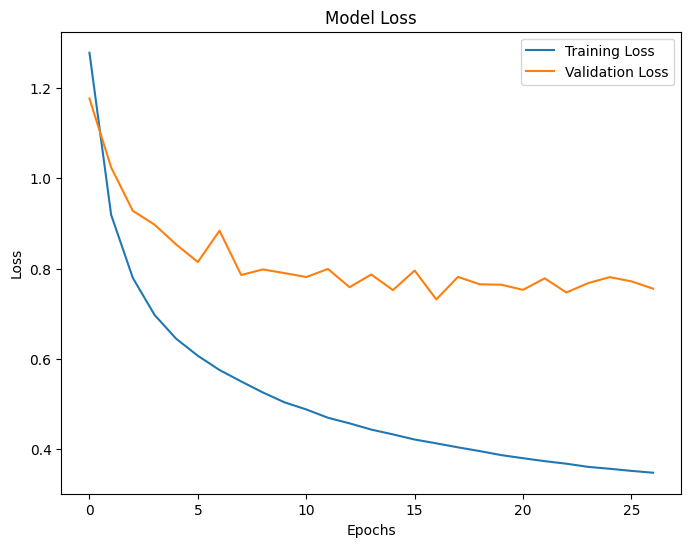

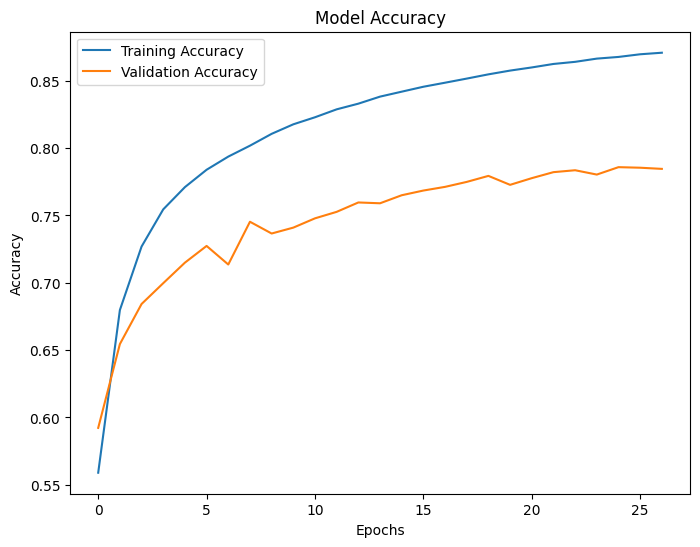

In [12]:
history = cnn


plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix


y_true = []
y_pred = []

for images, labels in test:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━

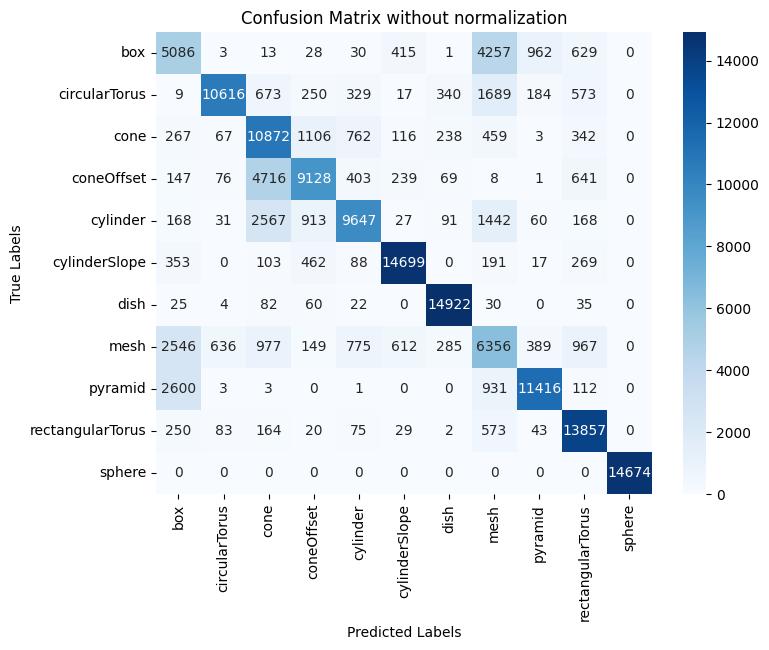

In [14]:


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix without normalization')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

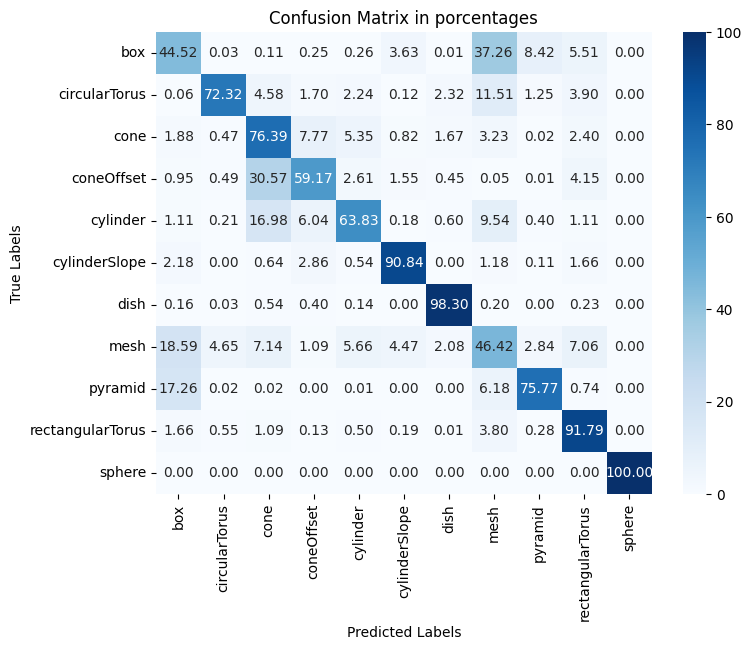

In [15]:

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix in porcentages')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [16]:
from sklearn.metrics import recall_score,f1_score,precision_score

In [17]:
recall_score(y_true, y_pred, average='weighted')

0.754335439888535

In [18]:
precision_score(y_true, y_pred, average='weighted')

0.7714435198706592

In [19]:
f1_score(y_true, y_pred, average='weighted')

0.7572220619189146